# Overview
Experiment with the ideas from [Unsupervised Learning of Visual Representations by Solving Jigsaw Puzzles](https://link.springer.com/chapter/10.1007/978-3-319-46466-4_5) by Mehdi Noroozi and Paolo Favaro. 

The core idea is to take an image, break it up into square tiles, scramble the tiles and have a model learn to unscramble them $\rightarrow$ "solving a jigsaw puzzle". The features the model learns on the individual tiles should then be useful for describing the important information in the image.

For this approach we try a more auto-encoder style meaning we try to produce the original image as well as the scramble permutation. Instead of generating the original image from features as some of the other models we, we attempt to use a dense Spatial Transformer to move the original tiles into the correct position and map the loss from the image reconstructed in that manner.

## Overview
- Create and test the jigsaw puzzle code (and the reconstruction)
- Setup scrambling
- Build a training and validation dataset
- Train the model to unscramble
- Evaluate performance and visualize what the model has done
- Use the features to try and classify digits

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
# tests help notebooks stay managable
import doctest
import copy
import functools

def autotest(func):
    globs = copy.copy(globals())
    globs.update({func.__name__: func})
    doctest.run_docstring_examples(
        func, globs, verbose=True, name=func.__name__)
    return func

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
from skimage.io import imread as imread
from skimage.util import montage
montage_rgb = lambda x, **kwargs: np.stack([montage(x[..., i], **kwargs) for i in range(x.shape[-1])], -1)
from itertools import product
from tqdm import tqdm_notebook
from IPython.display import clear_output

## Dense Spatial Transformer
Here we define the dense spatial transformer layer that takes an input image $(batch, x, y, d)$ and a offset image $(batch, x, y, 2)$ and stretches the input image according to the offset image. We have a few basic examples below but the technique is quite versatile and fully-differentiable which means we can learn the offset map (as we do below with the tile-slider model)

In [4]:
from keras.layers.core import Layer
from keras import layers, models
import tensorflow as tf

class Dense2DSpatialTransformer(Layer):
    """
    The layer takes an input image and an offset field and generates a transformed version of the image
    >>> lay_in = layers.Input((5, 5, 1))
    >>> lay_shift = layers.Input((5, 5, 2))
    >>> dst = Dense2DSpatialTransformer()
    >>> dst_lay = dst([lay_in, lay_shift])
    >>> dst_mod = models.Model(inputs=[lay_in, lay_shift], outputs=[dst_lay])
    >>> shift_img = np.full((1, 5, 5, 2), -1)
    >>> test_img = np.pad(np.eye(2), [(1, 2), (2, 1)]).astype(float).reshape((1, 5, 5, 1))
    >>> test_img[0, :, :, 0].astype(int)
    array([[0, 0, 0, 0, 0],
           [0, 0, 1, 0, 0],
           [0, 0, 0, 1, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0]])
    >>> dst_mod.predict([test_img, shift_img])[0, :, :, 0].astype(int)
    array([[0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 1, 0],
           [0, 0, 0, 0, 1],
           [0, 0, 0, 0, 0]])
    >>> shift_img[0, :, :, 1]*=-1
    >>> dst_mod.predict([test_img, shift_img])[0, :, :, 0].astype(int)
    array([[0, 0, 0, 1, 0],
           [0, 0, 0, 0, 1],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0]])
    >>> dst_mod.predict([2-test_img, shift_img])[0, :, :, 0].astype(int)
    array([[0, 2, 2, 1, 2],
           [0, 2, 2, 2, 1],
           [0, 2, 2, 2, 2],
           [0, 2, 2, 2, 2],
           [0, 0, 0, 0, 0]])
    """

    def __init__(self, **kwargs):
        super(Dense2DSpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) > 3:
            raise Exception('Spatial Transformer must be called on a list of length 2 or 3. '
                            'First argument is the image, second is the offset field.')

        if len(input_shape[1]) != 4 or input_shape[1][3] != 2:
            raise Exception('Offset field must be one 4D tensor with 2 channels. '
                            'Got: ' + str(input_shape[1]))

        self.built = True

    def call(self, inputs):
        return self._transform(inputs[0], inputs[1][:, :, :, 0],
                               inputs[1][:, :, :, 1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def _transform(self, I, dx, dy):

        batch_size = tf.shape(dx)[0]
        height = tf.shape(dx)[1]
        width = tf.shape(dx)[2]

        # Convert dx and dy to absolute locations
        x_mesh, y_mesh = self._meshgrid(height, width)
        x_mesh = tf.expand_dims(x_mesh, 0)
        y_mesh = tf.expand_dims(y_mesh, 0)

        x_mesh = tf.tile(x_mesh, [batch_size, 1, 1])
        y_mesh = tf.tile(y_mesh, [batch_size, 1, 1])
        x_new = dx + x_mesh
        y_new = dy + y_mesh

        return self._interpolate(I, x_new, y_new)

    def _repeat(self, x, n_repeats):
        rep = tf.transpose(
            tf.expand_dims(tf.ones(shape=tf.stack([n_repeats, ])), 1), [1, 0])
        rep = tf.cast(rep, dtype='int32')
        x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
        return tf.reshape(x, [-1])

    def _meshgrid(self, height, width):
        x_t = tf.matmul(tf.ones(shape=tf.stack([height, 1])),
                        tf.transpose(tf.expand_dims(tf.linspace(0.0,
                                                                tf.cast(width, tf.float32)-1.0, width), 1), [1, 0]))
        y_t = tf.matmul(tf.expand_dims(tf.linspace(0.0,
                                                   tf.cast(height, tf.float32)-1.0, height), 1),
                        tf.ones(shape=tf.stack([1, width])))

        return x_t, y_t

    def _interpolate(self, im, x, y):

        im = tf.pad(im, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")

        num_batch = tf.shape(im)[0]
        height = tf.shape(im)[1]
        width = tf.shape(im)[2]
        channels = tf.shape(im)[3]

        out_height = tf.shape(x)[1]
        out_width = tf.shape(x)[2]

        x = tf.reshape(x, [-1])
        y = tf.reshape(y, [-1])

        x = tf.cast(x, 'float32')+1
        y = tf.cast(y, 'float32')+1

        max_x = tf.cast(width - 1, 'int32')
        max_y = tf.cast(height - 1, 'int32')

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        x0 = tf.clip_by_value(x0, 0, max_x)
        x1 = tf.clip_by_value(x1, 0, max_x)
        y0 = tf.clip_by_value(y0, 0, max_y)
        y1 = tf.clip_by_value(y1, 0, max_y)
        
        dim3 = 1
        dim2 = width
        dim1 = width*height
        base = self._repeat(tf.range(num_batch)*dim1,
                            out_height*out_width)

        base_y0 = base + y0*dim2
        base_y1 = base + y1*dim2

        idx_a = base_y0 + x0*dim3 
        idx_b = base_y1 + x0*dim3
        idx_c = base_y0 + x1*dim3
        idx_d = base_y1 + x1*dim3
        idx_e = base_y0 + x0*dim3
        idx_f = base_y1 + x0*dim3
        idx_g = base_y0 + x1*dim3
        idx_h = base_y1 + x1*dim3

        # use indices to lookup pixels in the flat image and restore
        # channels dim
        im_flat = tf.reshape(im, tf.stack([-1, channels]))
        im_flat = tf.cast(im_flat, 'float32')

        Ia = tf.gather(im_flat, idx_a)
        Ib = tf.gather(im_flat, idx_b)
        Ic = tf.gather(im_flat, idx_c)
        Id = tf.gather(im_flat, idx_d)
        Ie = tf.gather(im_flat, idx_e)
        If = tf.gather(im_flat, idx_f)
        Ig = tf.gather(im_flat, idx_g)
        Ih = tf.gather(im_flat, idx_h)

        # and finally calculate interpolated values
        x1_f = tf.cast(x1, 'float32')
        y1_f = tf.cast(y1, 'float32')

        dx = x1_f - x
        dy = y1_f - y

        wa = tf.expand_dims((dx * dy), 1)
        wb = tf.expand_dims((dx * (1-dy)), 1)
        wc = tf.expand_dims(((1-dx) * dy), 1)
        wd = tf.expand_dims(((1-dx) * (1-dy)), 1)
        we = tf.expand_dims((dx * dy), 1)
        wf = tf.expand_dims((dx * (1-dy)), 1)
        wg = tf.expand_dims(((1-dx) * dy), 1)
        wh = tf.expand_dims(((1-dx) * (1-dy)), 1)

        output = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id,
                           we*Ie, wf*If, wg*Ig, wh*Ih])
        output = tf.reshape(output, tf.stack(
            [-1, out_height, out_width, channels]))/2.0
        return output
clear_output()
autotest(Dense2DSpatialTransformer) # can also be run seperately

Finding tests in Dense2DSpatialTransformer
Trying:
    lay_in = layers.Input((5, 5, 1))
Expecting nothing
ok
Trying:
    lay_shift = layers.Input((5, 5, 2))
Expecting nothing
ok
Trying:
    dst = Dense2DSpatialTransformer()
Expecting nothing
ok
Trying:
    dst_lay = dst([lay_in, lay_shift])
Expecting nothing
ok
Trying:
    dst_mod = models.Model(inputs=[lay_in, lay_shift], outputs=[dst_lay])
Expecting nothing
ok
Trying:
    shift_img = np.full((1, 5, 5, 2), -1)
Expecting nothing
ok
Trying:
    test_img = np.pad(np.eye(2), [(1, 2), (2, 1)]).astype(float).reshape((1, 5, 5, 1))
Expecting nothing
ok
Trying:
    test_img[0, :, :, 0].astype(int)
Expecting:
    array([[0, 0, 0, 0, 0],
           [0, 0, 1, 0, 0],
           [0, 0, 0, 1, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0]])
ok
Trying:
    dst_mod.predict([test_img, shift_img])[0, :, :, 0].astype(int)
Expecting:
    array([[0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 1, 0],
           [0, 0, 0, 0, 1],

__main__.Dense2DSpatialTransformer

In [5]:
from keras.datasets import cifar10
train_ds, test_ds = cifar10.load_data()
X_train, y_train = train_ds
X_test, y_test = test_ds
X_train = X_train/255.0
y_train = y_train[:, 0]
X_test = X_test/255.0
y_test = y_test[:, 0]
clear_output()
print(X_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000,)


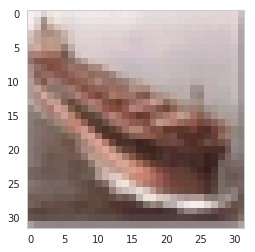

In [6]:
img_idx = np.random.choice(range(X_train.shape[0]))
plt.imshow(X_train[img_idx])

# Jigsaw Code
Here we write the jigsaw code to break the image up into a bunch of little pieces (```cut_jigsaw```) and reassemble the pieces back into an image (```jigsaw_to_image```). The methods right now are very simple, but are fairly easy to read and include a few basic test-cases. The code is implemented in a very intuitive, but inefficient manner. This should certainly be optimized before use on real problems.

In [7]:
@autotest
def cut_jigsaw(
    in_image, # type: np.ndarray
    x_wid, # type: int
    y_wid,# type: int
    gap=False,
    jitter=False,
    jitter_dim=None, # type: Optional[int]
):
    # type: (...) -> List[np.ndarray]
    """Cuts the image into little pieces
    :param in_image: the image to cut-apart
    :param x_wid: the size of the piece in x
    :param y_wid: the size of the piece in y
    :param gap: if there is a gap between tiles
    :param jitter: if the positions should be moved around
    :param jitter_dim: amount to jitter (default is x_wid or y_wid/2)
    :return : a 4D array with tiles x x_wid x y_wid * d
    Examples
    >>> test_image = np.arange(20).reshape((4, 5)).astype(int)
    >>> test_image
    array([[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]])
    >>> cut_jigsaw(test_image, 2, 2, False, False)
    array([[[ 0,  1],
            [ 5,  6]],
    <BLANKLINE>
           [[ 2,  3],
            [ 7,  8]],
    <BLANKLINE>
           [[10, 11],
            [15, 16]],
    <BLANKLINE>
           [[12, 13],
            [17, 18]]])
    >>> cut_jigsaw(test_image, 2, 2, True, False)
    array([[[ 0,  1],
            [ 5,  6]],
    <BLANKLINE>
           [[ 3,  4],
            [ 8,  9]],
    <BLANKLINE>
           [[10, 11],
            [15, 16]],
    <BLANKLINE>
           [[13, 14],
            [18, 19]]])
    >>> np.random.seed(0)
    >>> cut_jigsaw(test_image, 2, 2, True, True, 1)
    array([[[ 1,  2],
            [ 6,  7]],
    <BLANKLINE>
           [[ 7,  8],
            [12, 13]],
    <BLANKLINE>
           [[ 5,  6],
            [10, 11]],
    <BLANKLINE>
           [[ 7,  8],
            [12, 13]]])
    """
    if len(in_image.shape)==2:
        in_image = np.expand_dims(in_image, -1)
        expand = True
    else:
        expand = False
    x_size, y_size, d_size = in_image.shape
    out_tiles = []
    x_chunks = x_size//x_wid
    y_chunks = y_size//y_wid
    out_tiles = np.zeros((x_chunks*y_chunks, x_wid, y_wid, d_size), dtype=in_image.dtype)
    if gap:
        # we calculate the maximum gap and 
        x_gap = x_size-x_chunks*x_wid
        y_gap = y_size-y_chunks*y_wid
    else:
        x_gap, y_gap = 0, 0
    x_jitter = x_wid//2 if jitter_dim is None else jitter_dim
    y_jitter = y_wid//2 if jitter_dim is None else jitter_dim
    for idx, (i, j) in enumerate(product(range(x_chunks), range(y_chunks))):
        x_start = i*x_wid+min(x_gap, i)
        y_start = j*y_wid+min(y_gap, j)
        if jitter:
            x_range = max(x_start-x_jitter, 0), min(x_start+x_jitter+1, x_size-x_wid)
            y_range = max(y_start-y_jitter, 0), min(y_start+y_jitter+1, y_size-y_wid)
            
            x_start = np.random.choice(range(*x_range)) if x_range[1]>x_range[0] else x_start
            y_start = np.random.choice(range(*y_range)) if y_range[1]>y_range[0] else y_start
            
        out_tiles[idx, :, :, :] = in_image[x_start:x_start+x_wid, y_start:y_start+y_wid, :]
    
    return out_tiles[:, :, :, 0] if expand else out_tiles
                

Finding tests in cut_jigsaw
Trying:
    test_image = np.arange(20).reshape((4, 5)).astype(int)
Expecting nothing
ok
Trying:
    test_image
Expecting:
    array([[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]])
ok
Trying:
    cut_jigsaw(test_image, 2, 2, False, False)
Expecting:
    array([[[ 0,  1],
            [ 5,  6]],
    <BLANKLINE>
           [[ 2,  3],
            [ 7,  8]],
    <BLANKLINE>
           [[10, 11],
            [15, 16]],
    <BLANKLINE>
           [[12, 13],
            [17, 18]]])
ok
Trying:
    cut_jigsaw(test_image, 2, 2, True, False)
Expecting:
    array([[[ 0,  1],
            [ 5,  6]],
    <BLANKLINE>
           [[ 3,  4],
            [ 8,  9]],
    <BLANKLINE>
           [[10, 11],
            [15, 16]],
    <BLANKLINE>
           [[13, 14],
            [18, 19]]])
ok
Trying:
    np.random.seed(0)
Expecting nothing
ok
Trying:
    cut_jigsaw(test_image, 2, 2, True, True, 1)
Expecting:
 

In [8]:
@autotest
def jigsaw_to_image(
    in_tiles, # type: np.ndarray
    out_x, # type: int
    out_y, # type: int
    gap=False
):
    # type: (...) -> np.ndarray
    """Reassembles little pieces into an image
    :param in_tiles: the tiles to reassemble
    :param out_x: the size of the image in x (default is calculated automatically)
    :param out_y: the size of the image in y
    :param gap: if there is a gap between tiles
    :return : an image from the tiles
    Examples
    >>> test_image = np.arange(20).reshape((4, 5)).astype(int)
    >>> test_image
    array([[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]])
    >>> js_pieces = cut_jigsaw(test_image, 2, 2, False, False)
    >>> jigsaw_to_image(js_pieces, 4, 5)
    array([[ 0,  1,  2,  3,  0],
           [ 5,  6,  7,  8,  0],
           [10, 11, 12, 13,  0],
           [15, 16, 17, 18,  0]])
    >>> js_gap_pieces = cut_jigsaw(test_image, 2, 2, True, False)
    >>> jigsaw_to_image(js_gap_pieces, 4, 5, True)
    array([[ 0,  1,  0,  3,  4],
           [ 5,  6,  0,  8,  9],
           [10, 11,  0, 13, 14],
           [15, 16,  0, 18, 19]])
    >>> np.random.seed(0)
    >>> js_gap_pieces = cut_jigsaw(test_image, 2, 2, False, True)
    >>> jigsaw_to_image(js_gap_pieces, 4, 5, False)
    array([[ 1,  2,  6,  7,  0],
           [ 6,  7, 11, 12,  0],
           [ 6,  7,  7,  8,  0],
           [11, 12, 12, 13,  0]])
    """
    if len(in_tiles.shape)==3:
        in_tiles = np.expand_dims(in_tiles, -1)
        expand = True
    else:
        expand = False
    tile_count, x_wid, y_wid, d_size = in_tiles.shape
    x_chunks = out_x//x_wid
    y_chunks = out_y//y_wid
    out_image = np.zeros((out_x, out_y, d_size), dtype=in_tiles.dtype)
    
    if gap:
        x_gap = out_x-x_chunks*x_wid
        y_gap = out_y-y_chunks*y_wid
    else:
        x_gap, y_gap = 0, 0
        
    for idx, (i, j) in enumerate(product(range(x_chunks), range(y_chunks))):
        x_start = i*x_wid+min(x_gap, i)
        y_start = j*y_wid+min(y_gap, j)
        out_image[x_start:x_start+x_wid, y_start:y_start+y_wid] = in_tiles[idx, :, :]
    
    return out_image[:, :, 0] if expand else out_image
    
    
    

Finding tests in jigsaw_to_image
Trying:
    test_image = np.arange(20).reshape((4, 5)).astype(int)
Expecting nothing
ok
Trying:
    test_image
Expecting:
    array([[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]])
ok
Trying:
    js_pieces = cut_jigsaw(test_image, 2, 2, False, False)
Expecting nothing
ok
Trying:
    jigsaw_to_image(js_pieces, 4, 5)
Expecting:
    array([[ 0,  1,  2,  3,  0],
           [ 5,  6,  7,  8,  0],
           [10, 11, 12, 13,  0],
           [15, 16, 17, 18,  0]])
ok
Trying:
    js_gap_pieces = cut_jigsaw(test_image, 2, 2, True, False)
Expecting nothing
ok
Trying:
    jigsaw_to_image(js_gap_pieces, 4, 5, True)
Expecting:
    array([[ 0,  1,  0,  3,  4],
           [ 5,  6,  0,  8,  9],
           [10, 11,  0, 13, 14],
           [15, 16,  0, 18, 19]])
ok
Trying:
    np.random.seed(0)
Expecting nothing
ok
Trying:
    js_gap_pieces = cut_jigsaw(test_image, 2, 2, False, True)
Expecting nothi

# Jigsaw on MNIST Images
Here we start the actual code. We have some predefined constants below for the size of various layers and tiles. These should be optimized to be well suited for the problem at hand

In [9]:
TILE_X = 10
TILE_Y = 10
JITTER_SIZE = 3
TRAIN_TILE_COUNT = 2**14
VALID_TILE_COUNT = 2**11
KEEP_RANDOM_PERM = 150
LATENT_SIZE = 24
BIG_LATENT_SIZE = 64

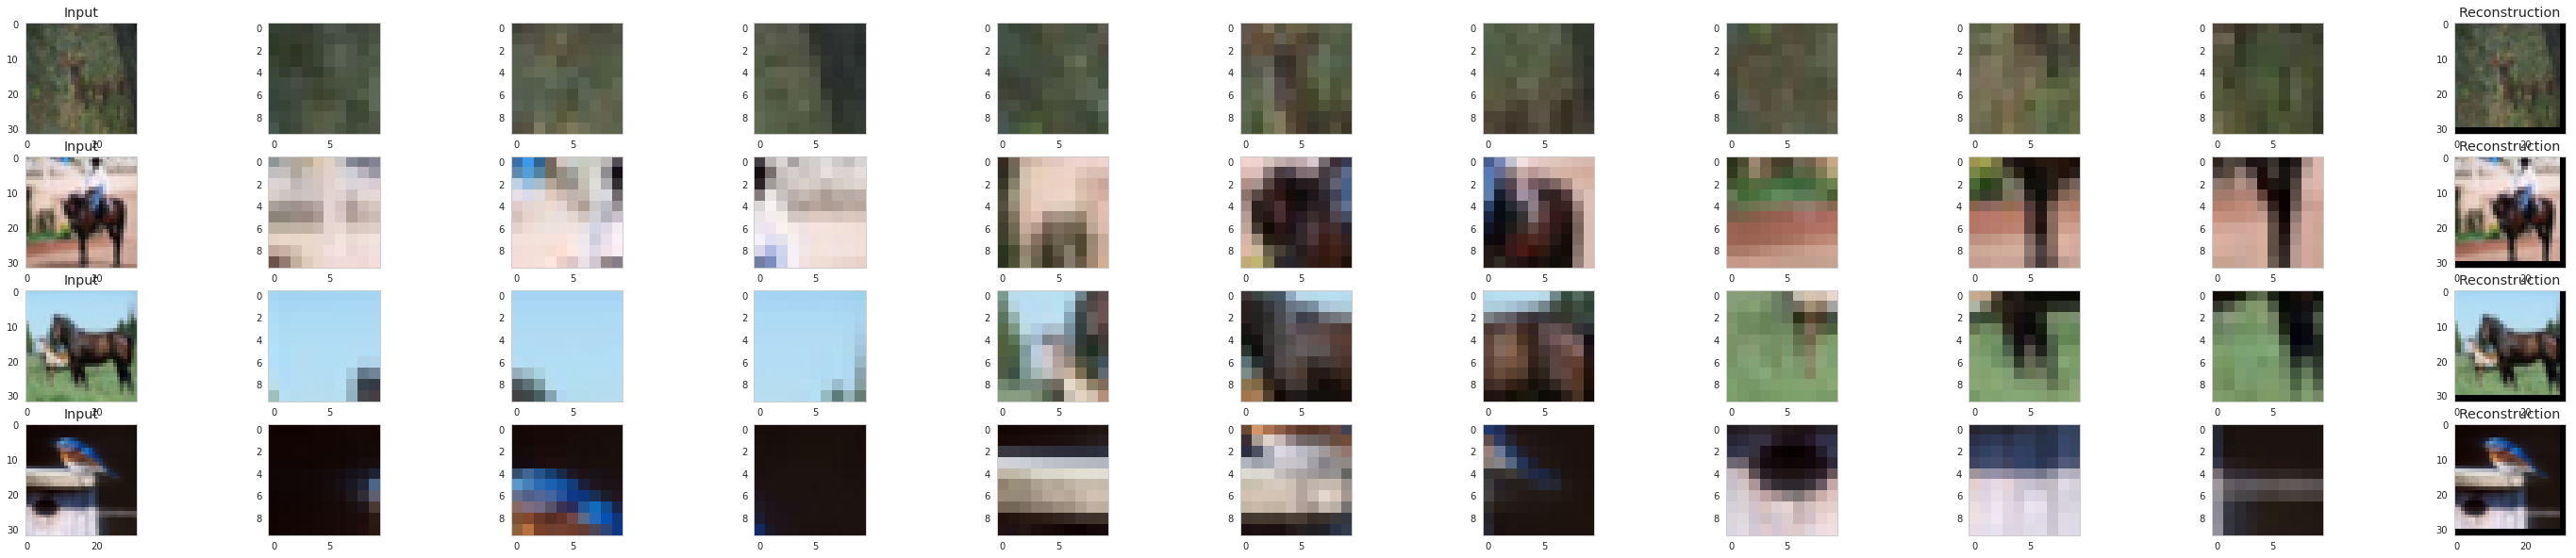

In [10]:
fig, m_axs = plt.subplots(4, 11, figsize=(50, 10))
for img_idx, c_axs in enumerate(m_axs, 10):
    c_axs[0].imshow(X_train[img_idx, :, :])
    c_axs[0].set_title('Input')
    out_tiles = cut_jigsaw(X_train[img_idx, :, :], TILE_X, TILE_Y, gap=False) 
    for k, c_ax in zip(range(out_tiles.shape[0]), c_axs[1:]):
        c_ax.imshow(out_tiles[k, :, :])
    recon_img = jigsaw_to_image(out_tiles, X_train.shape[1], X_train.shape[2])
    c_axs[-1].imshow(recon_img[:, :])
    c_axs[-1].set_title('Reconstruction')

# Scramble Combinations
We have $9!$ different possible permutations, but that is too many and is probably not a great problem to solve (since it is under-constained, there are alot of permutations where it would be hard to know what exactly is being matched to what.

In [11]:
from itertools import permutations
all_perm = np.array(list(permutations(range(out_tiles.shape[0]), out_tiles.shape[0])))
print('Permutation count:' , len(all_perm))

np.random.seed(2019)
# first one is always unmessed up
keep_perm = all_perm[0:1, :].tolist()+all_perm[np.random.choice(range(1, len(all_perm)), KEEP_RANDOM_PERM-1), :].tolist()

Permutation count: 362880


### Show combinations
Here we can show combinations along with various instances of jitter noise to see how much that affects the reconstruction

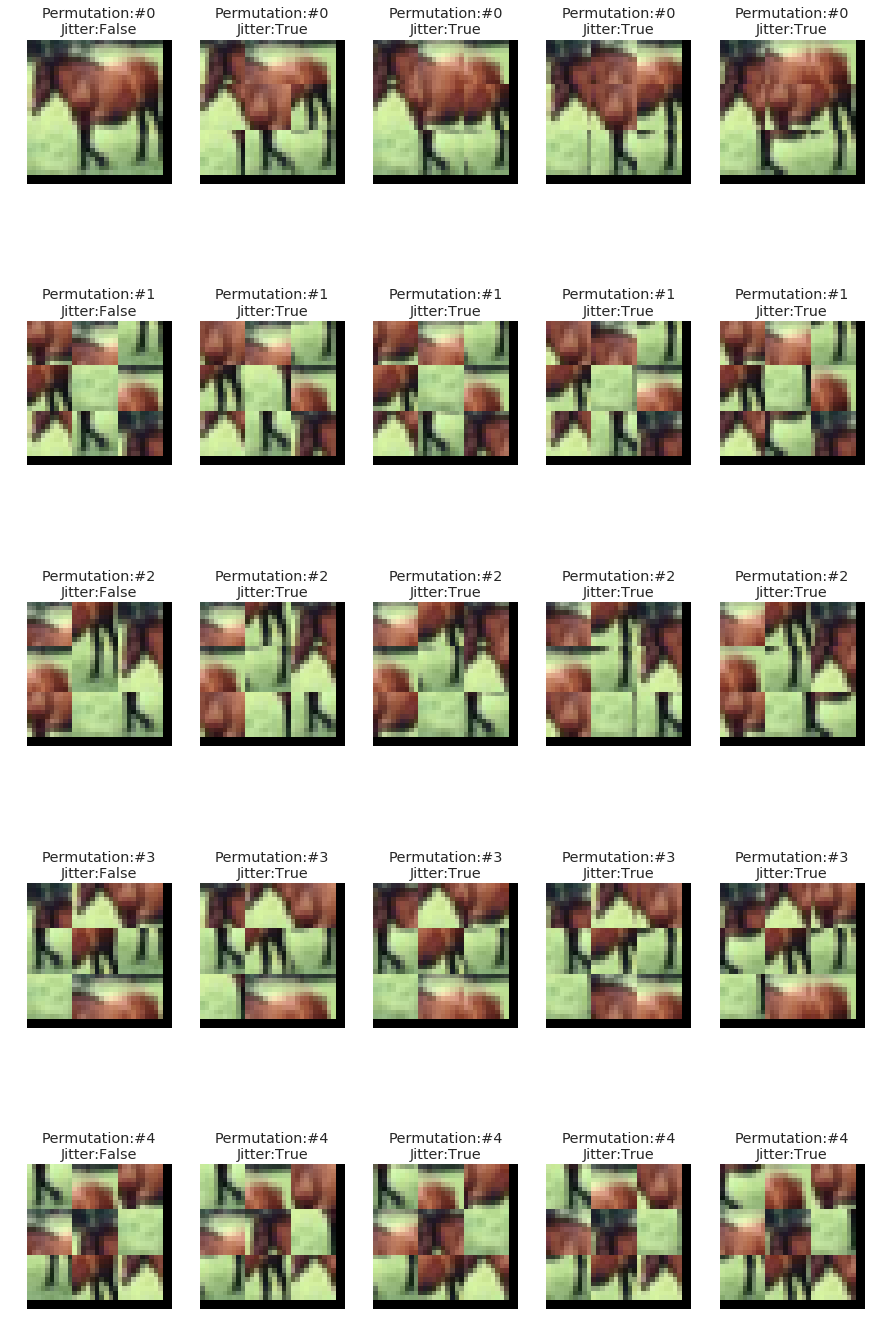

In [12]:
fig, m_axs = plt.subplots(5, 5, figsize=(15, 25))
for i, c_axs in enumerate(m_axs.T):
    out_tiles = cut_jigsaw(X_train[7], TILE_X, TILE_Y, gap=False, jitter=i>0, jitter_dim=JITTER_SIZE) 
    for j, (c_ax, c_perm) in enumerate(zip(c_axs, keep_perm)): 
        scrambled_tiles = out_tiles[c_perm]
        recon_img = jigsaw_to_image(scrambled_tiles, X_train.shape[1], X_train.shape[2])
        c_ax.imshow(recon_img)
        c_ax.set_title('Permutation:#{}\nJitter:{}'.format(j, i>0))
        c_ax.axis('off')

# Data Preparation
In order to train a model we need to pre-compute a whole bunch of data to train models with

In [13]:
out_tiles = cut_jigsaw(X_train[8, :, :], TILE_X, TILE_Y, gap=False) 

def _generate_batch(in_idx, is_valid=False):
    np.random.seed(in_idx)
    if is_valid:
        img_ds = X_test
    else:
        img_ds = X_train
    img_idx = np.random.choice(range(img_ds.shape[0]))
    out_tiles = cut_jigsaw(img_ds[img_idx, :, :], TILE_X, TILE_Y, gap=True, jitter=JITTER_SIZE>0, jitter_dim=JITTER_SIZE) 
    perm_idx = np.random.choice(range(len(keep_perm)))
    c_perm = keep_perm[perm_idx]
    return out_tiles[c_perm], perm_idx, img_ds[img_idx, :, :]

def make_tile_group(tile_count, is_valid=False):
    c_tiles = np.zeros((tile_count,)+out_tiles.shape, dtype='float32')
    c_perms = np.zeros((tile_count,), dtype='int')
    c_recon_image = np.zeros((tile_count,)+X_train.shape[1:], dtype='float32')
    for i in tqdm_notebook(range(tile_count)):
        # should be parallelized
        c_tiles[i], c_perms[i], c_recon_image[i] = _generate_batch(i, is_valid=is_valid)
    return c_tiles, c_perms, c_recon_image
train_tiles, train_perms, train_recons = make_tile_group(TRAIN_TILE_COUNT)
valid_tiles, valid_perms, valid_recons = make_tile_group(VALID_TILE_COUNT, is_valid=True)

# Model Building
## Encoder Model
We first build the tile encoder model to come up with a feature representation of the tiles

In [14]:
from keras import models, layers
tile_encoder = models.Sequential(name='TileEncoder')
# we use None to make the model more usuable later
tile_encoder.add(layers.BatchNormalization(input_shape=(None, None)+(train_tiles.shape[-1],)))
tile_encoder.add(layers.Conv2D(8, (3,3), padding='same', activation='linear'))
tile_encoder.add(layers.BatchNormalization())
tile_encoder.add(layers.MaxPool2D(2,2))
tile_encoder.add(layers.LeakyReLU(0.1))
tile_encoder.add(layers.Conv2D(16, (3,3), padding='same', activation='linear'))
tile_encoder.add(layers.BatchNormalization())
tile_encoder.add(layers.MaxPool2D(2,2))
tile_encoder.add(layers.LeakyReLU(0.1))
tile_encoder.add(layers.Conv2D(32, (2,2), padding='valid', activation='linear'))
tile_encoder.add(layers.BatchNormalization())
tile_encoder.add(layers.LeakyReLU(0.1))
tile_encoder.add(layers.Conv2D(LATENT_SIZE, (1,1), activation='linear'))
tile_encoder.add(layers.BatchNormalization())
tile_encoder.add(layers.LeakyReLU(0.1))
clear_output() # some annoying loading/warnings come up

In [15]:
tile_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, None, None, 3)     12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 8)     32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 8)     0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 8)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
batch_normalization_3 (Batch (None, None, None, 16)    64        
__________

In [16]:
print('Model Input Shape:', train_tiles.shape[2:], 
      '-> Model Output Shape:', tile_encoder.predict(np.zeros((1,)+train_tiles.shape[2:])).shape[1:])

Model Input Shape: (10, 10, 3) -> Model Output Shape: (1, 1, 24)


## Big Jigsaw Permutation Model
Here we reuse (shared-weights) the tile-encoder to process a number of tiles and predict which permutation is most likely.

The second head of the model tries to predict how to move each tile in order to get the best ouput image

In [17]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

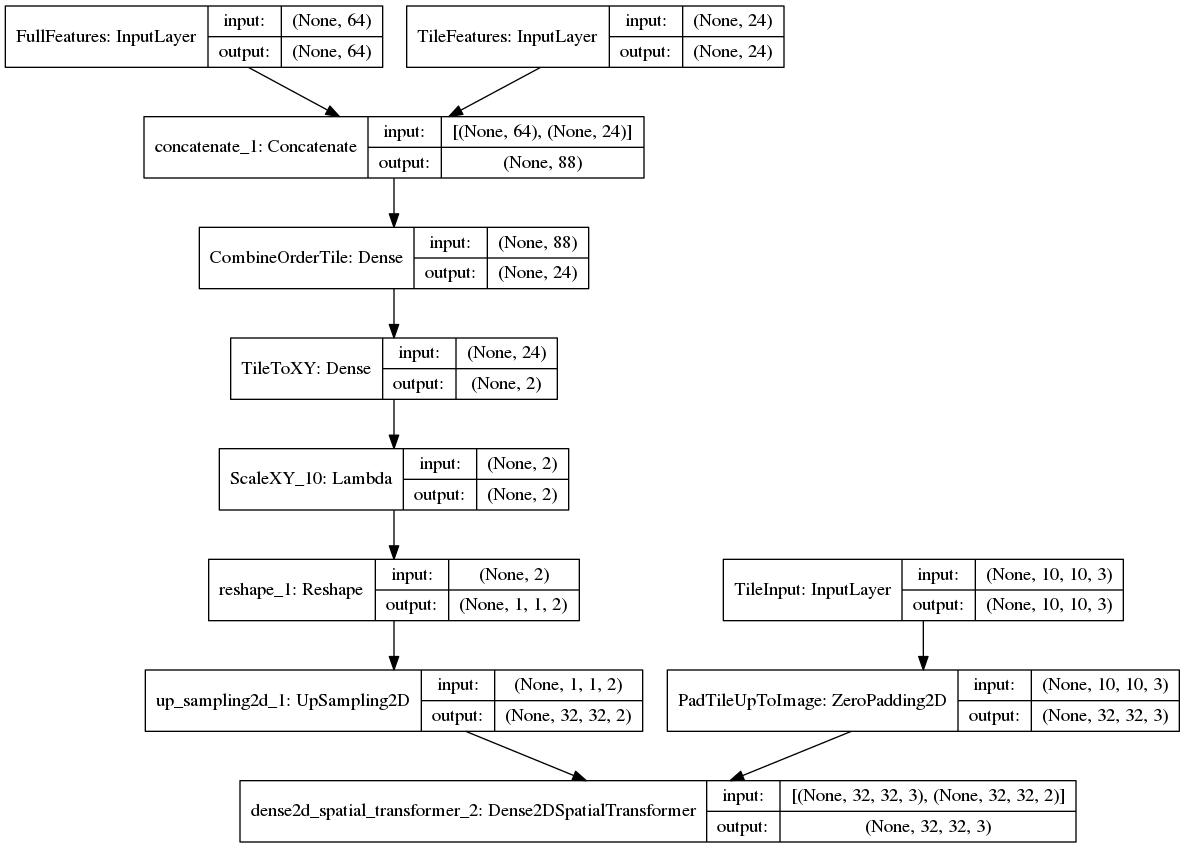

In [18]:
# here we build a mini-model to reconstruct the image from 3 vectors
full_X, full_Y, full_D = X_train.shape[1:]
x_pad = full_X-TILE_X
y_pad = full_Y-TILE_Y

tile_in = layers.Input((TILE_X, TILE_Y, X_train.shape[-1]), name='TileInput')
tile_features_in = layers.Input((LATENT_SIZE,), name='TileFeatures')
full_features_in = layers.Input((BIG_LATENT_SIZE,), name='FullFeatures')

pad_layer = layers.ZeroPadding2D(padding=((x_pad//2, x_pad-x_pad//2), (y_pad//2, y_pad-y_pad//2)), name='PadTileUpToImage')(tile_in)

comb_feat = layers.concatenate([full_features_in, tile_features_in])
order_plus_tile_layer = layers.Dense(LATENT_SIZE, name='CombineOrderTile')(comb_feat)
pos_xy = layers.Dense(2, activation='tanh', name='TileToXY')(order_plus_tile_layer)
pos_xy = layers.Lambda(lambda x: x*(x_pad-1)/2.0, name='ScaleXY_{}'.format((x_pad-1)//2))(pos_xy)

dens_st = Dense2DSpatialTransformer()

pos_xy_field = layers.Reshape((1, 1, 2))(pos_xy)
pos_xy_full = layers.UpSampling2D((full_X, full_Y))(pos_xy_field)
recon_image = dens_st([pad_layer, pos_xy_full])
tile_slide_model = models.Model(inputs=[tile_in, tile_features_in, full_features_in], 
                                outputs=[recon_image], 
                                name='SlideTile')
Image(model_to_dot(tile_slide_model, show_shapes=True).create_png())

In [19]:
big_in = layers.Input(train_tiles.shape[1:], name='All_Tile_Input')
image_x = []
feat_vec = []
for k in range(train_tiles.shape[1]):
    lay_x = layers.Lambda(lambda x: x[:, k], name='Select_{}_Tile'.format(k))(big_in)
    image_x += [lay_x]
    feat_x = tile_encoder(lay_x)
    feat_vec += [layers.GlobalAvgPool2D()(feat_x)]
feat_cat = layers.concatenate(feat_vec)
feat_dr = layers.Dropout(0.5)(feat_cat)
# learn the scrambling permutation
feat_latent = layers.Dense(BIG_LATENT_SIZE)(feat_dr)
feat_latent_dr = layers.Dropout(0.5)(feat_latent)
out_pred = layers.Dense(KEEP_RANDOM_PERM, activation='softmax', name='PermutationCategory')(feat_latent_dr)

# use fresh features for the tile_slide results
feat_latent_slide = layers.Dropout(0.5)(layers.Dense(BIG_LATENT_SIZE)(feat_dr))

# use the tile slide model on each tile
big_image = []
for c_img, c_feat in zip(image_x, feat_vec):
    big_image.append(tile_slide_model([c_img, c_feat, feat_latent_slide]))

recon_image = layers.add(big_image, name='ReconImage')
big_model = models.Model(inputs=[big_in], outputs=[out_pred, recon_image])
big_model.compile(optimizer='adam', 
                  loss={'PermutationCategory': 'sparse_categorical_crossentropy', 'ReconImage': 'mse'}, 
                  metrics={
                      'PermutationCategory': ['sparse_categorical_accuracy', 
                                              'sparse_top_k_categorical_accuracy'],
                      'ReconImage': ['mae', 
                                     'binary_accuracy']}
                 )

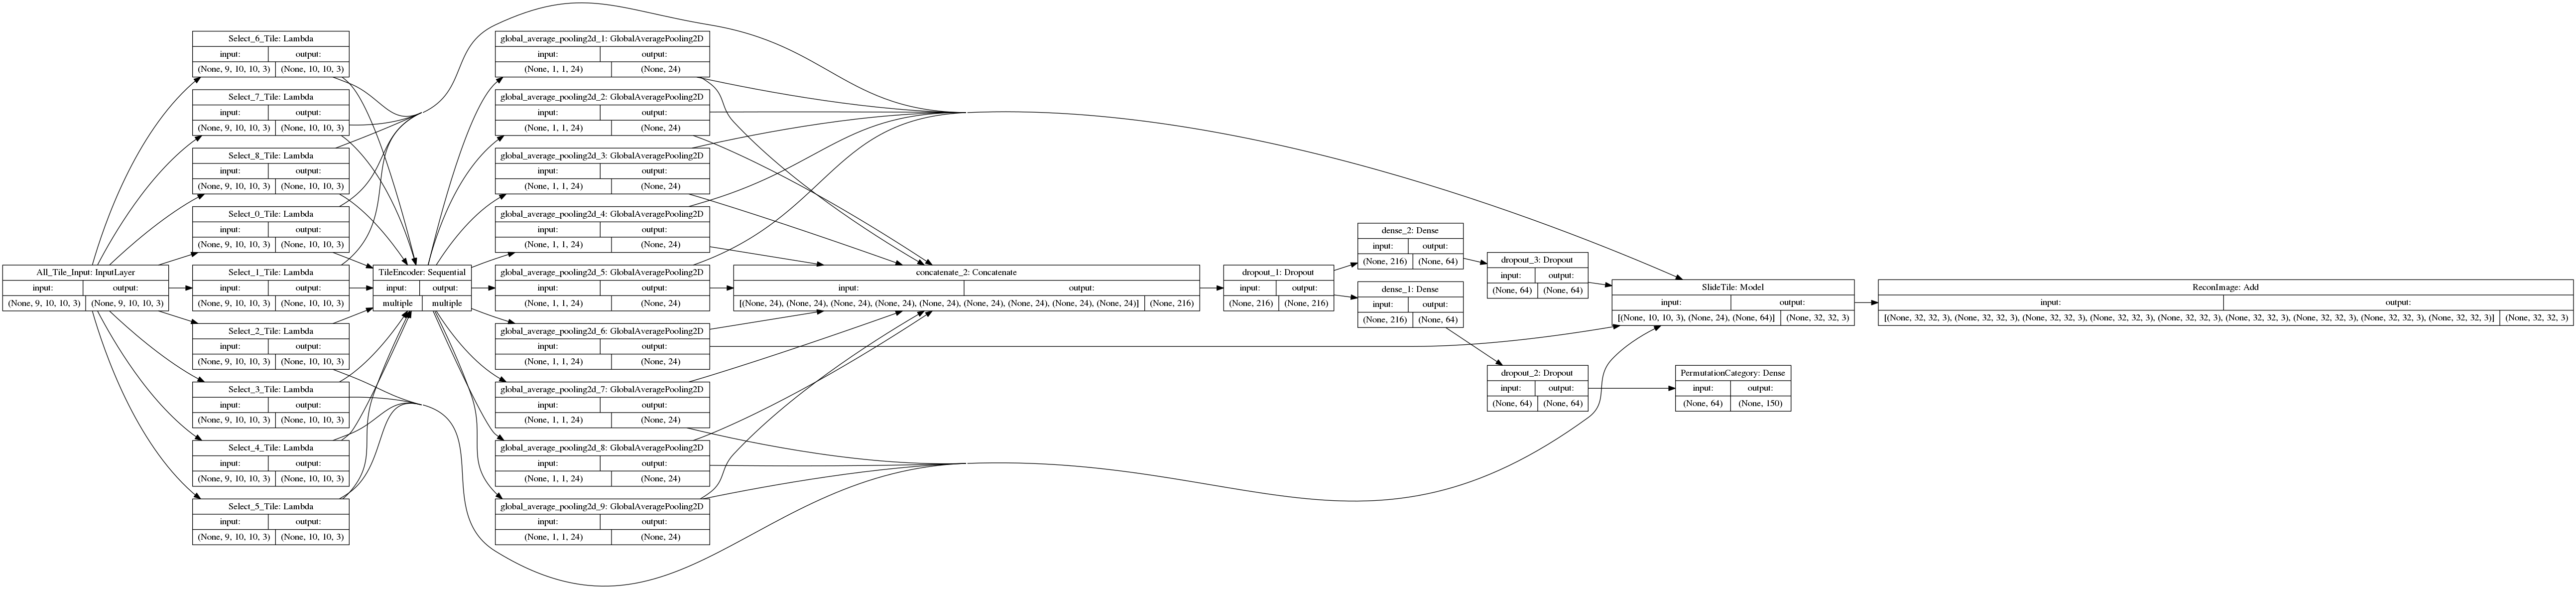

In [20]:
dot_model = model_to_dot(big_model, show_shapes=True)
dot_model.set_rankdir('LR')
Image(dot_model.create_png())

## Show Output
In order to show the model output we need to descramble the image with the given scrambling code. Given that a scrambling is a mapping from $i\rightarrow j$ we need to make a reverse mapping for each combination

In [21]:
reversed_keep_perm = [[c_dict[j] for j in range(out_tiles.shape[0])]
                      for c_dict in [{j: i for i, j in enumerate(c_perm)}
                                     for c_perm in keep_perm]]
for i in range(3):
    print('forward', keep_perm[i], 'reversed', reversed_keep_perm[i])

forward [0, 1, 2, 3, 4, 5, 6, 7, 8] reversed [0, 1, 2, 3, 4, 5, 6, 7, 8]
forward [4, 1, 8, 5, 6, 2, 3, 7, 0] reversed [8, 1, 5, 6, 0, 3, 4, 7, 2]
forward [1, 5, 0, 2, 8, 3, 4, 6, 7] reversed [2, 0, 3, 5, 6, 1, 7, 8, 4]


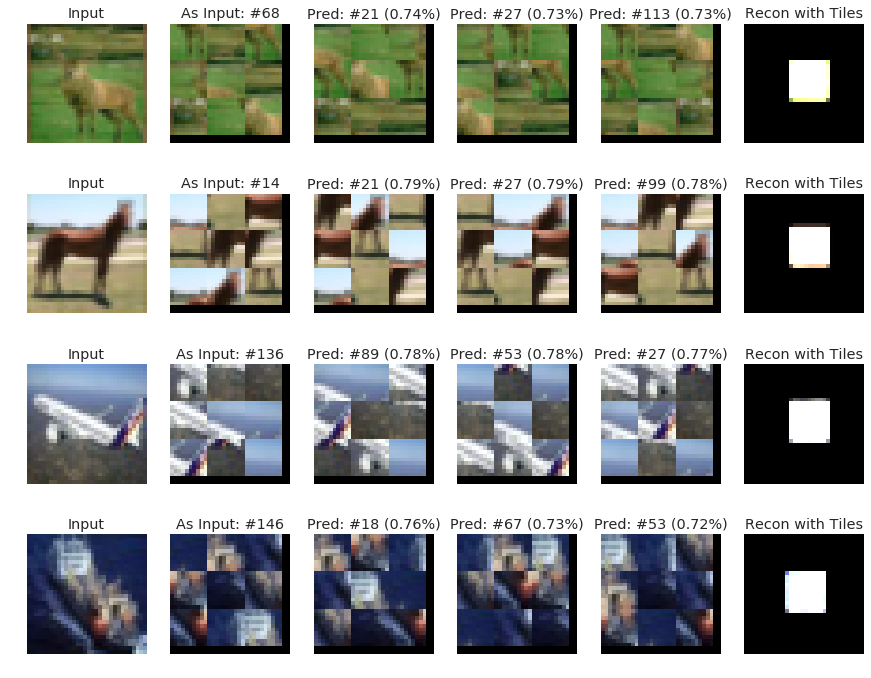

In [22]:
def show_model_output(image_count=4, perm_count=3): 
    fig, m_axs = plt.subplots(image_count, perm_count+3, figsize=(3*(perm_count+2), 3*image_count))
    [c_ax.axis('off') for c_ax in m_axs.flatten()]
    for img_idx, c_axs in enumerate(m_axs):
        img_idx = np.random.choice(range(X_train.shape[0]))
        perm_idx = np.random.choice(range(len(keep_perm)))
        c_axs[0].imshow(X_train[img_idx])
        
        c_axs[0].set_title('Input')
        # generate tiles
        out_tiles = cut_jigsaw(X_train[img_idx, :, :], TILE_X, TILE_Y, gap=True, jitter=JITTER_SIZE>0, jitter_dim=JITTER_SIZE)
        # scramble tiles
        
        c_perm = keep_perm[perm_idx]
        scr_tiles = out_tiles[c_perm]
        recon_img = jigsaw_to_image(scr_tiles, X_train.shape[1], X_train.shape[2])
        # show scrambled input
        c_axs[1].imshow(recon_img)
        c_axs[1].set_title('As Input: #{}'.format(perm_idx))
        # get model prediction
        out_pred, out_recon = big_model.predict(np.expand_dims(scr_tiles, 0))
        out_pred = out_pred[0]
        
        for c_ax, k_idx in zip(c_axs[2:-1], np.argsort(-1*out_pred)):
            pred_rev_perm = reversed_keep_perm[k_idx]
            recon_img = jigsaw_to_image(scr_tiles[pred_rev_perm], X_train.shape[1], X_train.shape[2])
            c_ax.imshow(recon_img)
            c_ax.set_title('Pred: #{} ({:2.2%})'.format(k_idx, out_pred[k_idx]))
        
        c_axs[-1].imshow(out_recon[0])
        c_axs[-1].set_title('Recon with Tiles')
show_model_output()

In [23]:
fit_results = big_model.fit(train_tiles, {'PermutationCategory': train_perms, 'ReconImage': train_recons}, 
                            validation_data=(valid_tiles, {'PermutationCategory': valid_perms, 'ReconImage': valid_recons}),
                            batch_size=128,
                            epochs=100,
                           verbose=False)
clear_output()

Text(0.5, 1.0, 'Reconstruction\nAccuracy')

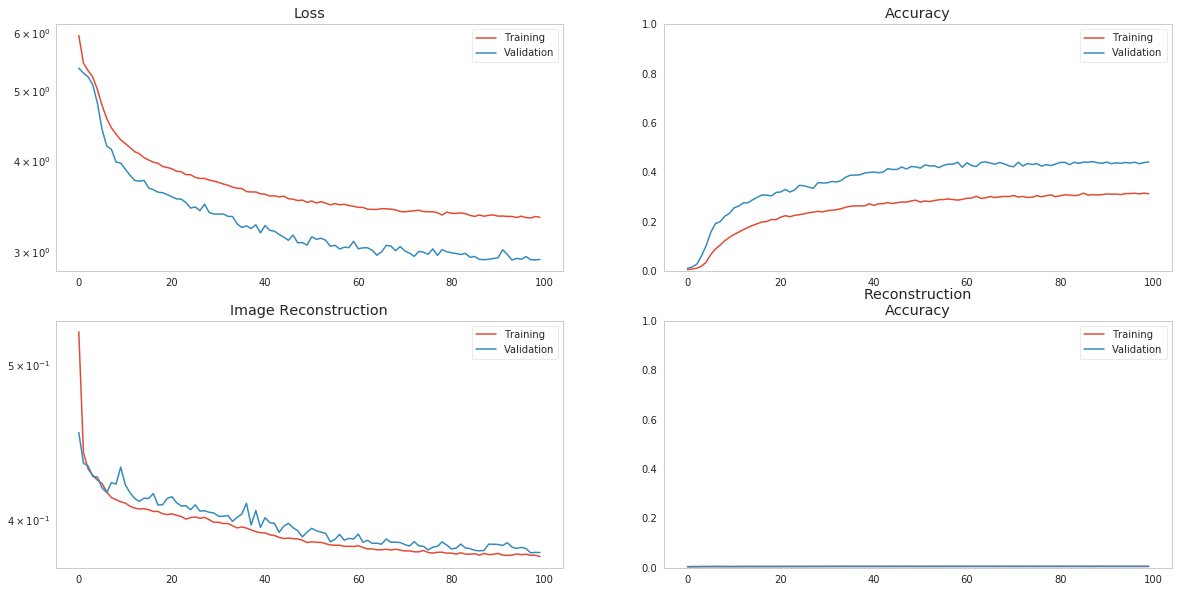

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20, 10))
ax1.semilogy(fit_results.history['loss'], label='Training')
ax1.semilogy(fit_results.history['val_loss'], label='Validation')
ax1.legend()
ax1.set_title('Loss')
ax2.plot(fit_results.history['PermutationCategory_sparse_categorical_accuracy'], label='Training')
ax2.plot(fit_results.history['val_PermutationCategory_sparse_categorical_accuracy'], label='Validation')
ax2.legend()
ax2.set_title('Accuracy')
ax2.set_ylim(0, 1)

ax3.semilogy(fit_results.history['ReconImage_mean_absolute_error'], label='Training')
ax3.semilogy(fit_results.history['val_ReconImage_mean_absolute_error'], label='Validation')
ax3.legend()
ax3.set_title('Image Reconstruction')
      
ax4.plot(fit_results.history['ReconImage_binary_accuracy'], label='Training')
ax4.plot(fit_results.history['val_ReconImage_binary_accuracy'], label='Validation')
ax4.legend()
ax4.set_ylim(0, 1)
ax4.set_title('Reconstruction\nAccuracy')

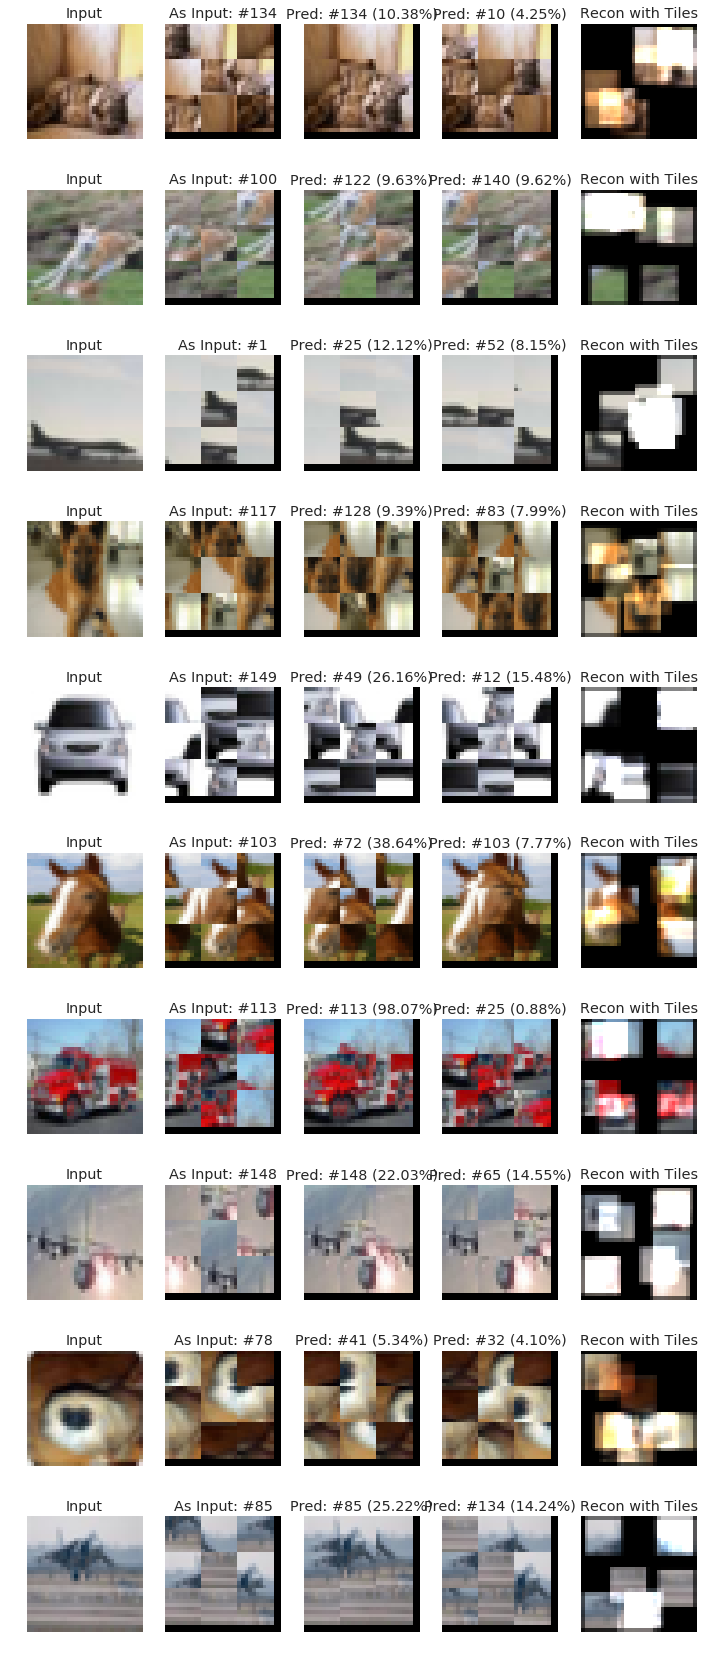

In [25]:
show_model_output(image_count=10, perm_count=2)

# Did we learn useful intermediate representations?
So we have a nice pretrained model that seems to have figured out how to solve the jigsaw puzzle (sometimes). Can we do anything with it?
- Use the model to calculate features on all of the images in MNIST
- See if the feature space has anything meaningful

## Look at the filters
We can examine the filters and try to see what the model was doing?

dict_keys([(1, 'conv2d_1'), (5, 'conv2d_2'), (9, 'conv2d_3'), (12, 'conv2d_4')])


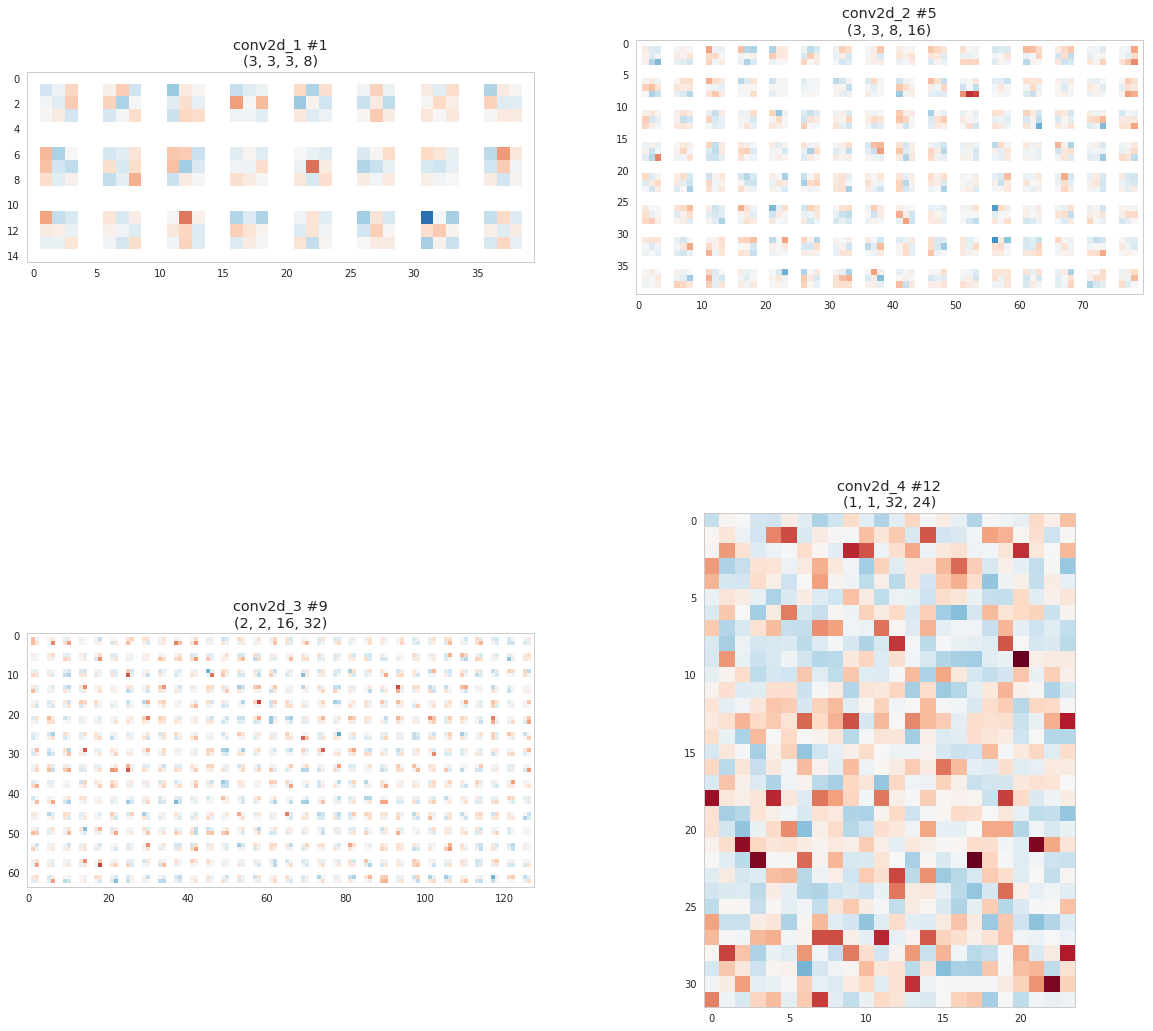

In [26]:
conv_weight_dict = {(idx, k.name): k.get_weights() for idx, k in enumerate(tile_encoder.layers) if isinstance(k, layers.Conv2D)}
print(conv_weight_dict.keys())
fig, m_axs = plt.subplots(2, 2, figsize=(20, 20))
for c_ax, ((idx, lay_name), [W, b]) in zip(m_axs.flatten(), conv_weight_dict.items()):
    c_ax.set_title('{} #{}\n{}'.format(lay_name, idx, W.shape))
    flat_W = W.reshape((W.shape[0], W.shape[1], -1)).swapaxes(0, 2).swapaxes(1,2)
    if flat_W.shape[1]>1 or flat_W.shape[2]>1:
        pad_W = np.pad(flat_W, [(0, 0), (1, 1), (1,1)], mode='constant', constant_values=np.NAN)
        pad_W = montage(pad_W, fill=np.NAN, grid_shape=(W.shape[2], W.shape[3]))
    else:
        pad_W = W[0, 0]
    c_ax.imshow(pad_W, vmin=-1, vmax=1, cmap='RdBu')
    

(8, 3, 3, 3) 0.5147118940949434


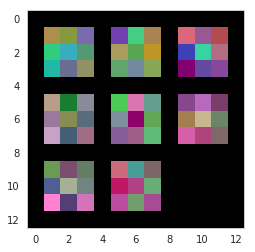

In [27]:
rgb_conv_W, _ = list(conv_weight_dict.values())[0]
rgb_conv_W = rgb_conv_W.swapaxes(0, 3).swapaxes(1, 3).swapaxes(1, 2)
offset_val = np.percentile(np.abs(rgb_conv_W), 99)
print(rgb_conv_W.shape, offset_val)
rgb_conv_W = np.clip((rgb_conv_W+offset_val)/(2*offset_val), 0, 1)
pad_W = montage_rgb(rgb_conv_W, fill=np.NAN, padding_width=1)
plt.imshow(pad_W)

## Find the most activating imaging channels
We can run all of the images through the model and record all of the intermediate points

In [28]:
gp_outputs = []
for k in tile_encoder.layers:
    if isinstance(k, layers.LeakyReLU):
        c_output = k.get_output_at(0)
        c_smooth = layers.AvgPool2D((2, 2))(c_output)
        c_gp = layers.GlobalMaxPool2D(name='GP_{}'.format(k.name))(c_smooth)
        gp_outputs += [c_gp]
activation_tile_encoder = models.Model(inputs = tile_encoder.inputs, 
                                       outputs = gp_outputs)
activation_maps = dict(zip(activation_tile_encoder.output_names, activation_tile_encoder.predict(X_train, batch_size=128, verbose=True)))

for k, v in activation_maps.items():
    print(k, v.shape)

50000/50000 [==============================] - 2s 44us/step
GP_leaky_re_lu_1 (50000, 8)
GP_leaky_re_lu_2 (50000, 16)
GP_leaky_re_lu_3 (50000, 32)
GP_leaky_re_lu_4 (50000, 24)


### Activated Neurons
Here we show each intermediate layer (panel) with each neuron/depth-channel (row) and the top-n images for activating that pattern (columns). Each row should more or less represent the kinds of images that particular neuron is sensitive too.

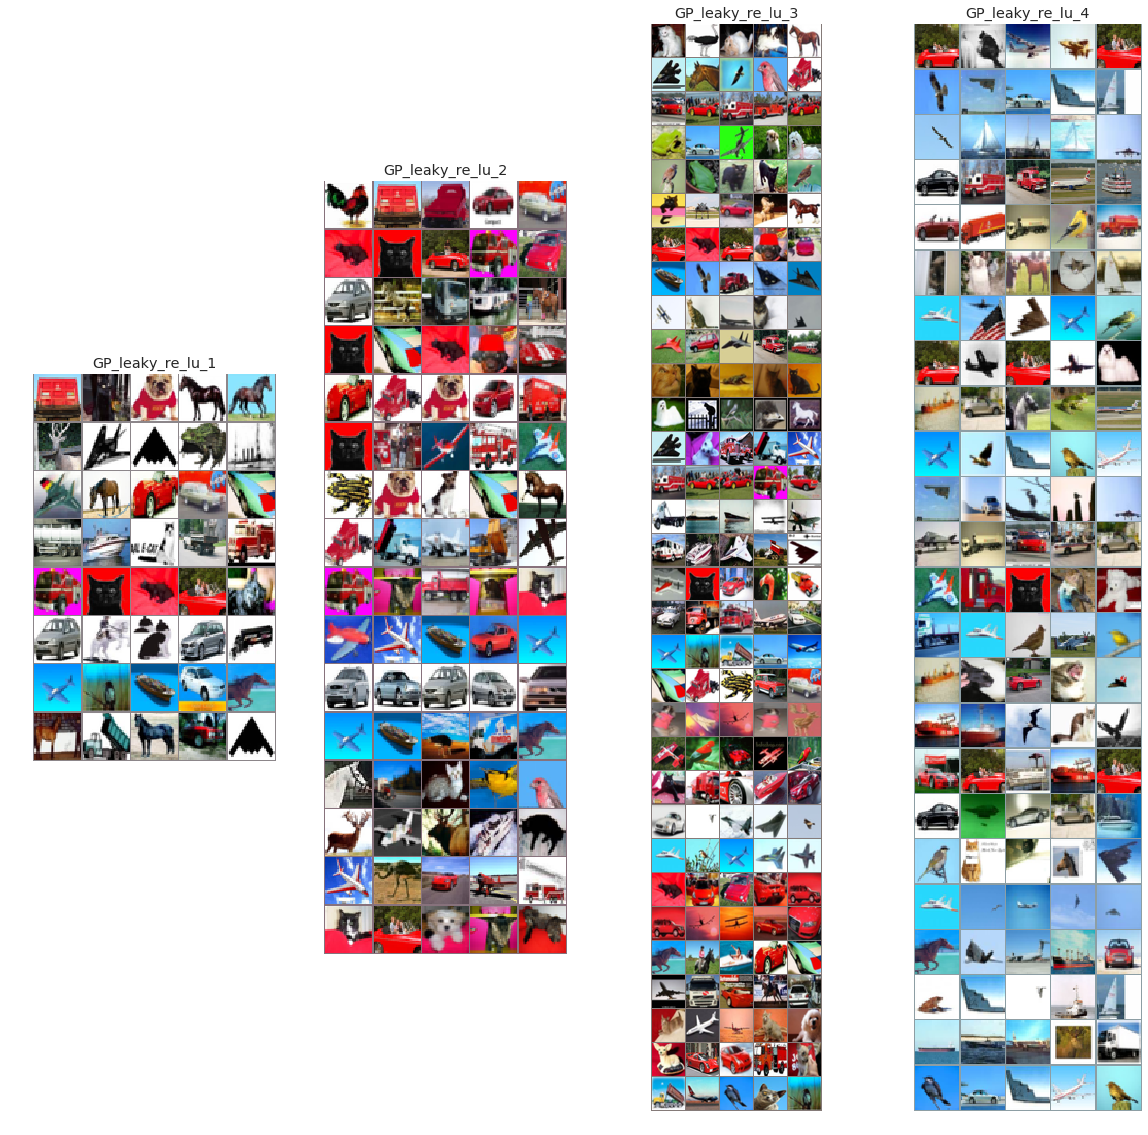

In [29]:
keep_top_n = 5
fig, m_axs = plt.subplots(1, len(activation_maps), figsize=(20, 20))
for c_ax, (k, v) in zip(m_axs.T, activation_maps.items()):
    c_ax.set_title(k)
    active_rows = []
    for i in range(v.shape[1]):
        top_idx = np.argsort(-np.abs(v[:, i]))[:keep_top_n]
        active_rows += [X_train[top_idx, :, :]]
    c_ax.imshow(montage_rgb(np.concatenate(active_rows, 0), grid_shape=(v.shape[1], keep_top_n), padding_width=1))
    c_ax.axis('off')

## Convert into an Image Model
We throw in global average pooling to turn the output of the `tile_encoder` into a single feature-vector. We can then use this feature vector as a basis classifying image.

In [30]:
print(X_train[0].shape, '->', tile_encoder.predict(X_train[0:1]).shape)

(32, 32, 3) -> (1, 7, 7, 24)


In [31]:
img_in = layers.Input(X_train.shape[1:])
full_feat_mat = tile_encoder(img_in)
gap_out = layers.GlobalAvgPool2D()(full_feat_mat)
image_encoder = models.Model(inputs=[img_in], outputs=[gap_out], name='EncodeImage')
image_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
TileEncoder (Sequential)     multiple                  4596      
_________________________________________________________________
global_average_pooling2d_10  (None, 24)                0         
Total params: 4,596
Trainable params: 4,430
Non-trainable params: 166
_________________________________________________________________


In [32]:
X_features = image_encoder.predict(X_train, batch_size=128)

## Calculate TSNE
We can see if the TSNE space seperates the digits well (we will quantify this later)

In [33]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=40, verbose=2, n_iter=250, early_exaggeration=1)
X_tsne = tsne.fit_transform(X_features)
clear_output()

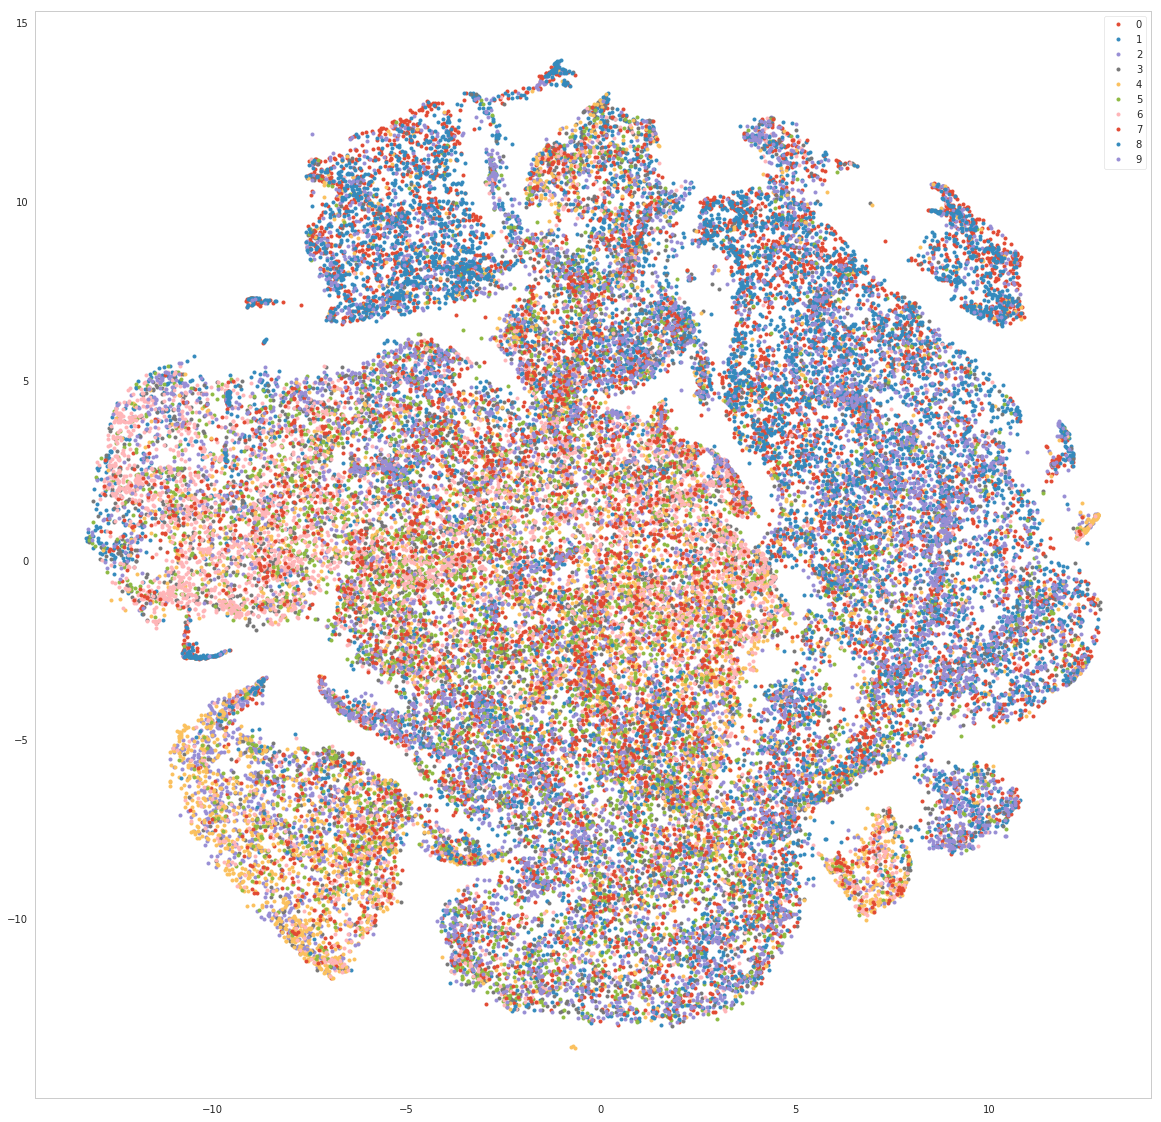

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
for k in np.unique(y_train):
    ax1.plot(X_tsne[y_train==k, 0], X_tsne[y_train==k, 1], '.', label='{}'.format(k))
ax1.legend()

# Fitting Models
Here we try to fit models with the features created by the tile-encoder. I try logistic regression as the baseline and then see if random forest or SVMs are able to do any better.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # too slow
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

## Comparison to Pixel-based Methods
We compare every model to what the performance would have been had it been trained directly on the raw pixel data.

In [36]:
def train_and_show_model(in_model, train_size=X_train.shape[0]//2, random_state=2019, show_figure=True):
    train_imgs, test_imgs, train_feat, test_feat, train_y, test_y = train_test_split(
        X_train,
        X_features, 
        y_train, 
        random_state=random_state, 
        test_size=X_train.shape[0]-train_size,
        stratify=y_train
    )
    # fit pixel model
    baseline_model = make_pipeline(Normalizer(), in_model)
    baseline_model.fit(train_imgs.reshape((train_imgs.shape[0], -1)), train_y)
    baseline_pred_y = baseline_model.predict(test_imgs.reshape((test_imgs.shape[0], -1)))
    
    # fit feature model
    feat_model = make_pipeline(Normalizer(), in_model)
    feat_model.fit(train_feat, train_y)
    pred_y = feat_model.predict(test_feat)
    if show_figure:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        sns.heatmap(confusion_matrix(test_y, baseline_pred_y), annot=True, fmt='d', ax=ax1)
        ax1.set_title('Pixel Accuracy: {:2.1%}'.format(accuracy_score(test_y, baseline_pred_y)))

        sns.heatmap(confusion_matrix(test_y, pred_y), annot=True, fmt='d', ax=ax2)
        ax2.set_title('Feature Accuracy: {:2.1%}'.format(accuracy_score(test_y, pred_y)))
    return {
        'train_size': train_imgs.shape[0],
        'random_state': random_state,
        'pixel_accuracy': accuracy_score(test_y, baseline_pred_y),
        'feature_accuracy': accuracy_score(test_y, pred_y)
    }

## Logistic Regression

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


{'train_size': 25000,
 'random_state': 2019,
 'pixel_accuracy': 0.4004,
 'feature_accuracy': 0.3452}

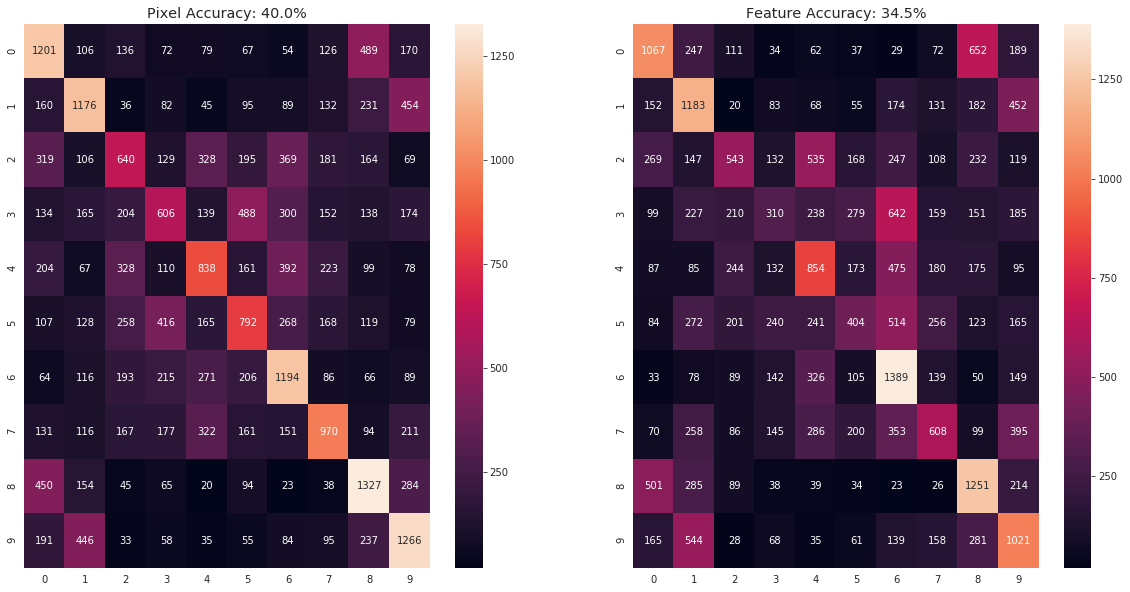

In [37]:
train_and_show_model(LogisticRegression(solver='lbfgs', multi_class='auto'))

## Show a slightly more complicated model

{'train_size': 25000,
 'random_state': 2019,
 'pixel_accuracy': 0.44464,
 'feature_accuracy': 0.35116}

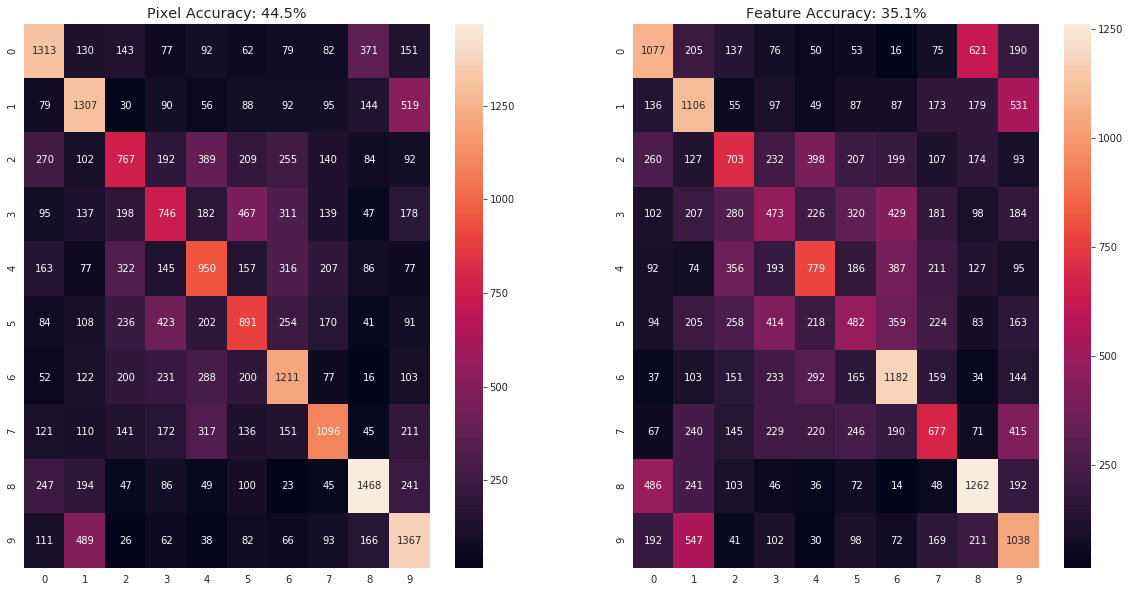

In [38]:
train_and_show_model(RandomForestClassifier(n_estimators=100))

## Increasing Training Size
Here we try and evaluate how well the model works as we increase the sample count. We provide the `test_size` as the sample count (as an integer) and the `random_state` to allow multiple runs to be done to make sure there aren't strong sample specific dependencies.

### Run lots of models
Running multiple models with multiple parameters is very time consuming so we use dask to run them in parallel.

In [39]:
import gc; gc.enable(); gc.collect() # memory gets very tight
model_fn = lambda : RandomForestClassifier(n_estimators=25, random_state=2019, n_jobs=1)
parm_seq = product(np.logspace(1, 3, 10).astype(int), # sample size
                          np.arange(6))

map_fn = lambda args: train_and_show_model(model_fn(),
                                     train_size=args[0], 
                                     random_state=args[1],
                                    show_figure=False)
USE_DASK = False

if USE_DASK:
    import dask
    from dask import bag
    import dask.diagnostics as diag
    from multiprocessing.pool import ThreadPool
    
    parm_sweep = bag.\
        from_sequence(parm_seq).\
        map(map_fn)
    print(parm_sweep)
    with diag.ProgressBar(), dask.config.set(pool = ThreadPool(2)):
        parm_df = pd.DataFrame(parm_sweep.compute())
else:
    from tqdm import tqdm_notebook
    parm_df = pd.DataFrame([map_fn(args) for args in tqdm_notebook(list(parm_seq))])

In [40]:

# clean-up the output
nice_parm_df = pd.melt(parm_df, id_vars=['train_size', 'random_state']).\
    rename(columns={'value': 'Test Accuracy', 'variable': 'input'})
nice_parm_df['Test Accuracy']*=100
nice_parm_df['input'] = nice_parm_df['input'].map(lambda x: x.split('_accuracy')[0])
nice_parm_df['Samples Per Class'] = nice_parm_df['train_size']/np.unique(y_train).shape[0]
nice_parm_df.head(3) 

train_size  random_state    input  Test Accuracy  Samples Per Class
0          10             0  feature      14.626925                1.0
1          10             1  feature      16.995399                1.0
2          10             2  feature      12.512503                1.0

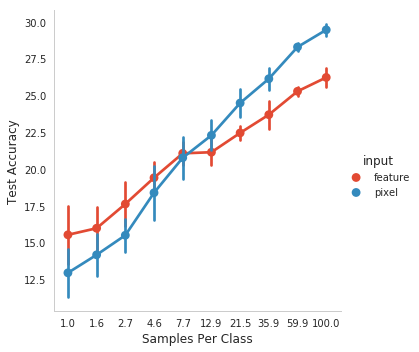

In [41]:
sns.catplot(x='Samples Per Class', 
            y='Test Accuracy', 
            hue='input', 
            kind='point',
            alpha=0.5,
            ci='sd',
            data=nice_parm_df)

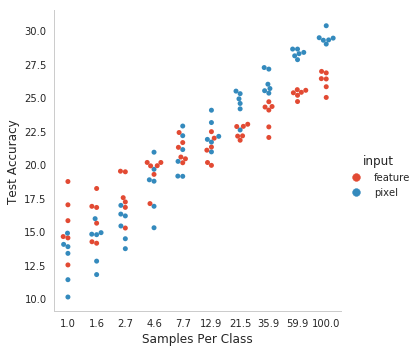

In [42]:
sns.catplot(x='Samples Per Class', 
            y='Test Accuracy', 
            hue='input', 
            kind='swarm',
            data=nice_parm_df)

## To be continued
...